In [5]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")
    

### Get the data

In [6]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [7]:
fetch_housing_data()

In [8]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [9]:
# taking a look at the data
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [10]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [11]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [12]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


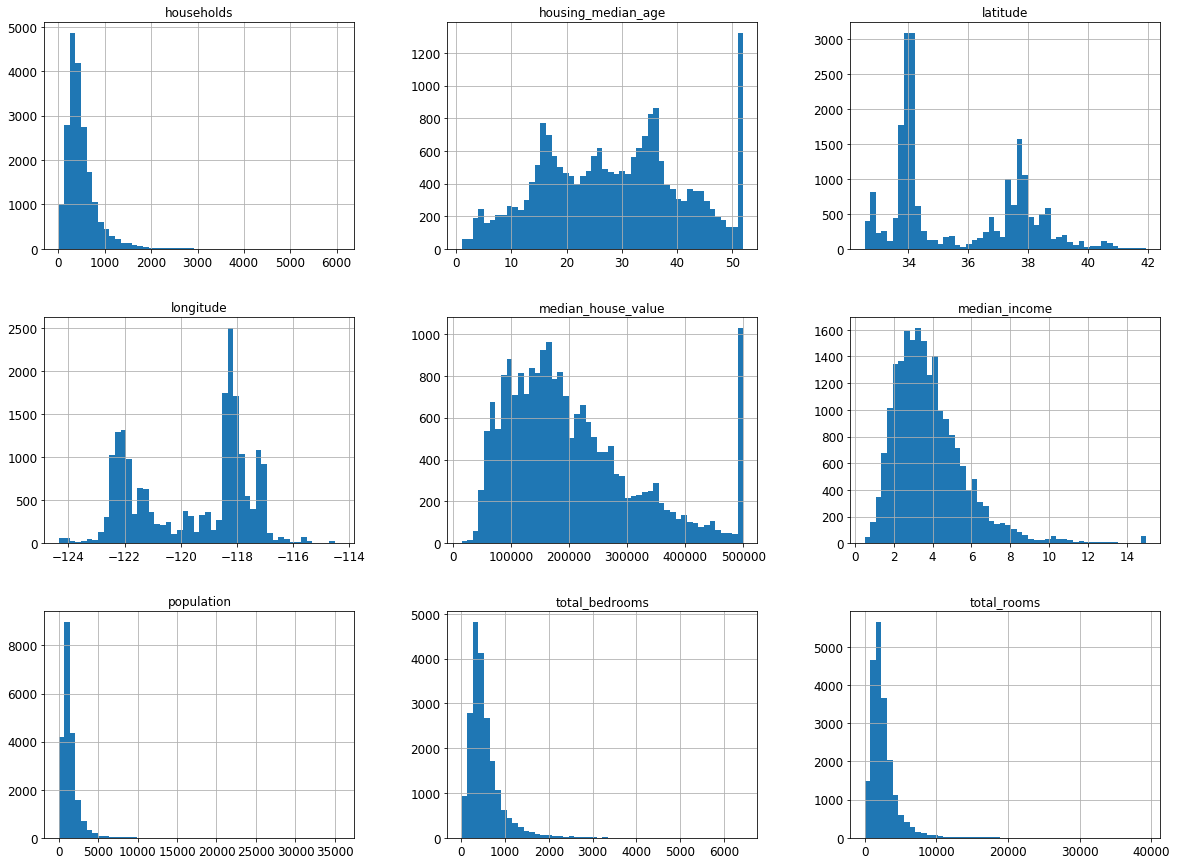

In [13]:
housing.hist(bins = 50, figsize = (20, 15))
plt.show()

### Stratified sampling
In order to avoid introducing sampling bias - use stratified sampling where the 
population is divided into subgroups - strata and the right number of instances are sampled 
from each stratum to guarantee that the test set is representative of the overall population.

_Stratification is the process of dividing members of the population into homogenous subgroups before sampling._

The median income is a important attribute to predict housing prices. We want to ensure the test is representative of the various categories of incomes in the whole dataset. As the income is a continous value it is converted to a category attribute. 

It is important to have a sufficient number of instances in the dataset for each stratum or else the estimate of the stratum's importance may be biased. 

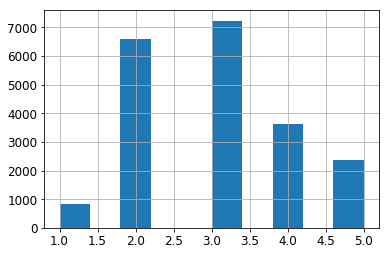

In [14]:
# creating income category attribute 

housing['income_cat'] = np.ceil(housing['median_income'] / 1.5)

# keeping only categories lower than five and where the condition is false the value is set to five
housing['income_cat'].where(housing['income_cat'] < 5, 5.0, inplace = True)

housing['income_cat'].hist()


In [15]:
# applying stratified sampling based on income category 

from sklearn.model_selection import StratifiedShuffleSplit 

split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)

for train_index, test_index in split.split(housing, housing['income_cat']): 
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [16]:
# overviewing the income category proportions 

strat_test_set['income_cat'].value_counts() / len(strat_test_set)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64

In [17]:
# comparing it to the proportions in the full dataset 

housing['income_cat'].value_counts() / len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [18]:
# removing the income_cat attribute to put data back to its original state

for set_ in (strat_train_set, strat_test_set): 
    set_.drop('income_cat', axis = 1, inplace = True)

In [19]:
# put the test set away only to explore the train set 

housing = strat_test_set.copy()

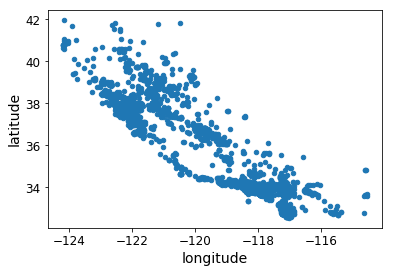

In [20]:
# creating a scatter plot of all districts to visualize the data

housing.plot(kind = 'scatter', x = 'longitude', y = 'latitude')

<Figure size 1440x720 with 0 Axes>

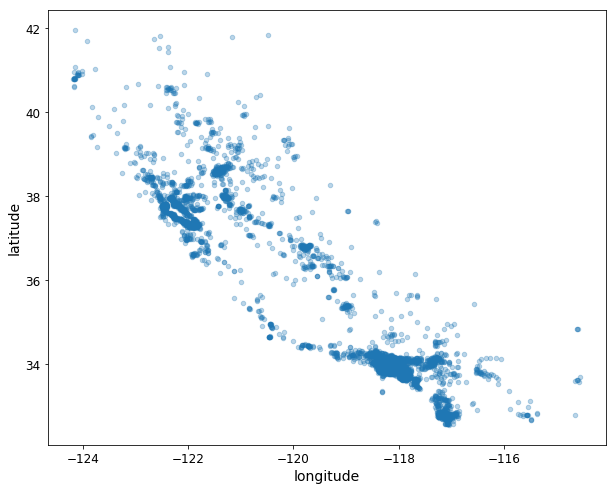

In [21]:
# include visualization of high density data points

plt.figure(figsize = (20, 10))
housing.plot(kind = 'scatter', x = 'longitude', y = 'latitude', alpha = 0.3, figsize = (10, 8))

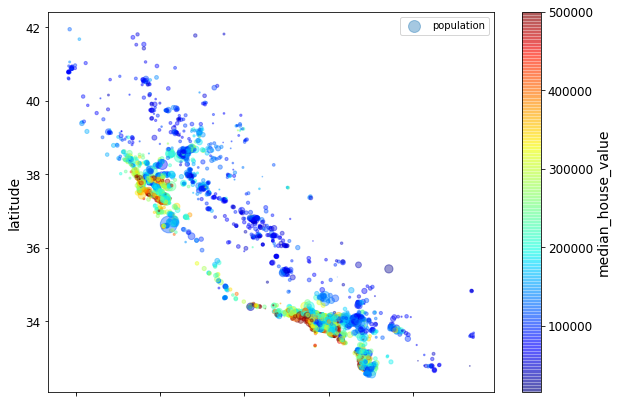

In [22]:
# plotting the housing prices, the radius of each circle represents the district's population and 
# color map represents the price 

housing.plot(kind = 'scatter', x = 'longitude', y = 'latitude', alpha = 0.4, 
                s = housing['population']/100, label = 'population', figsize = (10,7),
                c = 'median_house_value', cmap = plt.get_cmap('jet'), colorbar = True)
plt.legend()

In [23]:
# housing are very much relatedto the location and the population density 
# calculating the standard correlation coefficient between every pair of attributes 

corr_matrix = housing.corr()

corr_matrix['median_house_value'].sort_values(ascending = False)

median_house_value    1.000000
median_income         0.691831
total_rooms           0.131435
housing_median_age    0.071357
households            0.071242
total_bedrooms        0.057568
population           -0.016033
longitude            -0.039987
latitude             -0.150124
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000019C0B636F98>,
      dtype=object)

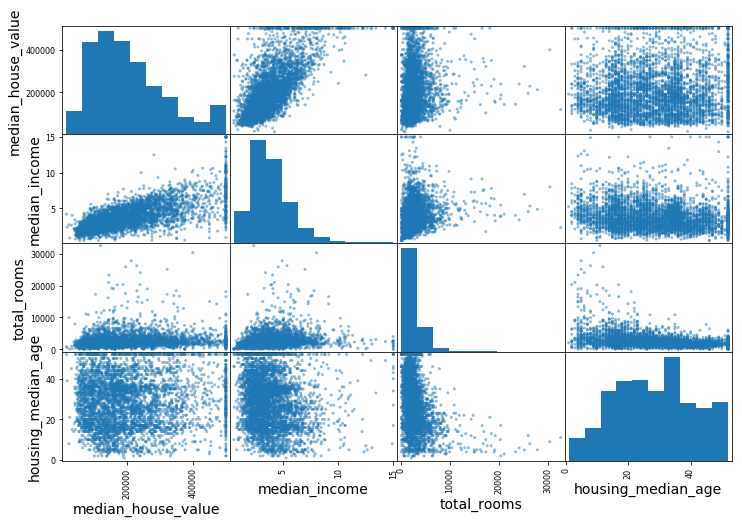

In [24]:
# checking correlation between attributes using scatter_matrix 

from pandas.plotting import scatter_matrix 

attributes = ['median_house_value', 'median_income', 'total_rooms', 
             'housing_median_age']
scatter_matrix(housing[attributes], figsize = (12,8))

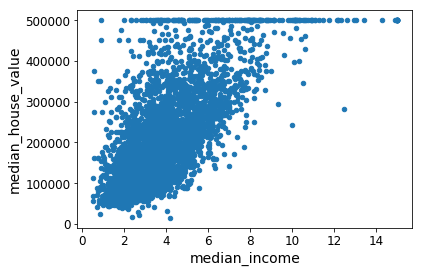

In [25]:
# most promising attribute to predict the median house value is the median income 

housing.plot(kind = 'scatter', x = 'median_income', y = 'median_house_value', alpha = 1)

In [26]:
# introducing new attribute combinations 

housing['rooms_per_household'] = housing['total_rooms']/housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms']/housing['total_rooms']
housing['population_per_household'] = housing['population']/housing['households']

In [27]:
# looking at the new correlation matrix

corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending = False)

median_house_value          1.000000
median_income               0.691831
rooms_per_household         0.192575
total_rooms                 0.131435
housing_median_age          0.071357
households                  0.071242
total_bedrooms              0.057568
population                 -0.016033
longitude                  -0.039987
population_per_household   -0.135142
latitude                   -0.150124
bedrooms_per_room          -0.240362
Name: median_house_value, dtype: float64

In [28]:
housing = strat_train_set.drop('median_house_value', axis = 1) # drop creates a copy of the frame 

housing_labels = strat_train_set['median_house_value'].copy()

In [29]:
# total_bedrooms have some missing values, using SimpleImputer to replace missing values 

# SimpleImputer fills missing values using a certain strategy 

from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy = 'median')

# median can only be computed on numerical attributes, creating a copy of the data without 
# text attribute ocean_proximity 

housing_num = housing.drop('ocean_proximity', axis = 1)

imputer.fit(housing_num)

# median for each attribute stored in statistics_ instance variable
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [30]:
X = imputer.transform(housing_num)

# putting data back to a dataframe

housing_tr = pd.DataFrame(X, columns = housing_num.columns)

housing_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16512 entries, 0 to 16511
Data columns (total 8 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16512 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
dtypes: float64(8)
memory usage: 1.0 MB


### Handling text and categorical attributes

In [31]:
# taking care of the categorical attribute

housing_cat = housing['ocean_proximity']
housing_cat.head(10)

# converting categories from text to numbers by using pandas factorize method 

housing_cat_encoded, housing_categories = housing_cat.factorize()

housing_cat_encoded



array([0, 0, 1, ..., 2, 0, 3], dtype=int64)

In [32]:
# using the SciKit-learn built in OneHotEncoderto convert integer categorical values into one-hot 
# vectors 

from sklearn.preprocessing import OneHotEncoder 

encoder = OneHotEncoder()

housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1, 1))
housing_cat_1hot # output from encoder.fit_transform() is a SciPy sparse matrix 


C:\Users\knajf\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [33]:
from sklearn.preprocessing import LabelEncoder 

label_encoder = LabelEncoder()

housing_label_1hot = label_encoder.fit_transform(housing_cat)

housing_label_1hot = encoder.fit_transform(housing_label_1hot.reshape(-1,1))
housing_label_1hot.toarray()

C:\Users\knajf\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [34]:
one_hot_frame = pd.DataFrame(data = housing_label_1hot.toarray(),
                             columns = ['1h_ocean', 'near_ocean', 'inland', 'near_bay', 'island'])

housing_tr = housing_tr.join(one_hot_frame)

In [35]:
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,1h_ocean,near_ocean,inland,near_bay,island
0,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,1.0,0.0,0.0,0.0,0.0
1,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,1.0,0.0,0.0,0.0,0.0
2,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,0.0,0.0,0.0,0.0,1.0
3,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,0.0,1.0,0.0,0.0,0.0
4,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,1.0,0.0,0.0,0.0,0.0


### Custom transformers 

The need for writing own tasks for customized cleanup operations or combining specific attributes. The transformer should work seamlessly with Scikit-Learn functionalities (e.g. pipelines). Scikit-Learn relies on duck typing (if a object contains certain methods rather than type of object itself). 

To create a custom transformer and implement three methods, namely: 

-fit()
-transform()
-fit_transform() - gets added by including TransformerMixin as a base class 

If BaseEstimator is included as a base class one gets get_params() and set_params() methods that will be useful for automatic hyperparameter tuning. 



In [36]:
# creating transformer class that adds the attributes combined together earlier 

from sklearn.base import BaseEstimator, TransformerMixin

# retrieving indexes for wanted columns 
rooms_ix, bedrooms_ix, population_ix, household_ix = [
        list(housing.columns).index(col)
        for col in ('total_rooms', 'total_bedrooms', 'population', 'households')]

class CombinedAttributesAdder(BaseEstimator, TransformerMixin): 
    def __init__(self, add_bedrooms_per_room = True): 
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y = None): 
        return self # nothing else to do 
    def transform(self, X, y = None): 
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room: 
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, household_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else: 
            return np.c_[X, rooms_per_household, population_per_household]
        
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room = False)
housing_extra_attributes = attr_adder.transform(housing.values)

# by including hyperparameters in transform method lead to that one easily can infer 
# whether adding this extra attribute helps the Machine Learning algorithm or not 

# general - add a hyperparameter to gate any data preparation step that you are not 100% sure about. 





In [37]:
# alternative way of creating a custom transformer

from sklearn.preprocessing import FunctionTransformer

def add_extra_features(X, add_bedrooms_per_room=True):
    rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
    population_per_household = X[:, population_ix] / X[:, household_ix]
    if add_bedrooms_per_room:
        bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
        return np.c_[X, rooms_per_household, population_per_household,
                     bedrooms_per_room]
    else:
        return np.c_[X, rooms_per_household, population_per_household]

attr_adder = FunctionTransformer(add_extra_features, validate=False,
                                 kw_args={"add_bedrooms_per_room": False})

### Feature scaling 

Most Machine Learning algorithms don't perform well without having the data one the same scale. 

Usally not required to transform target labels. 

Common methods: MinMaxScaling and Standardization 

### Transformation pipelines

Scikit-Learn Pipeline class assists with sequences of transformations 

When calling Pipeline.fit() is calls fit_transform() sequentially passing the output of each call as the parameter to the next call until it reaches the final estimator, for which it just calls the fit() method. 

In [38]:
# creating pipeline for the numerical attributes 

from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import StandardScaler 

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy = 'median')), 
    ('attribs_adder',FunctionTransformer(add_extra_features, validate=False)), 
    ('std_scaler', StandardScaler()), # all but last estimator must have a fit_transform() method
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [39]:
# writing a custom transformer to handle Pandas Dataframes instead of numpy arrays to be able to 
# send DataFrames directly into the pipeline 

from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin): 
    def __init__(self, attribute_names): 
        self.attribute_names = attribute_names
    def fit(self, X, y = None): 
        return self
    def transform(self, X): 
        return X[self.attribute_names].values
    


Writing another Pipeline for the categorical attributes and using the user-defined function to convert DataFrame-columns into numpy arrays as initial transform method in the pipeline 

In [40]:
num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer', SimpleImputer(strategy = 'median')), 
    ('attribs_adder', FunctionTransformer(add_extra_features, validate = False)),
    ('std_scaler', StandardScaler()), 
])

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)), 
    ('cat_encoder', CategoricalEncoder(encoding = 'onehot-dense')), 
])

# combining both numerical and categorical pipeline using FeatureUnion 

from sklearn.pipeline import FeatureUnion 

full_pipeline = FeatureUnion(transformer_list = [
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline),
])

housing_prepared = full_pipeline(fit_transform(housing))

# doesn't work since it was compatibable with earlier versions of scikit-learn 

NameError: name 'CategoricalEncoder' is not defined

In [41]:
# new way to solve it 

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', FunctionTransformer(add_extra_features, validate=False)),
        ('std_scaler', StandardScaler()),
    ])

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

from sklearn.compose import ColumnTransformer 

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

In [42]:
# fitting a linear regression model to the training data 
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [43]:
# trying out the model on some data instances 

some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print('predictions:', lin_reg.predict(some_data_prepared))
print('labels:', list(some_labels))

predictions: [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]
labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [44]:
# measure the RMSE on the whole training set 

from sklearn.metrics import mean_squared_error 

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_mse = np.sqrt(lin_mse)
lin_mse # average prediction error of almost 69000 dollars - not that very good. 

# seems like the model is underfitting the data 

68628.19819848923

### Underfitting 

This prediction error implies underfitting which means either that the features do not provide enough information to make good predictions or that the model is not powerful enough. 

In [45]:
# trying DecisionTreeRegressor - a complex model capable of finding complex nonlinear relationships
# in the data

from sklearn.tree import DecisionTreeRegressor 

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

### Overfitting the data 

The model is clearly overfitting. However, the test set should not be touched until a confident model has been selected, so the training data should in fact be split into training and validation data.

One way to evaluate the Decision Tree model would be to use the train_test_split function to split the training set into a smaller traning set and a validation set, then train the models against the smaller traning set and evaluate then against the validation set. 

Use Scikit-Learn cross-vadlidation feature! 


In [46]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels, 
                         scoring = 'neg_mean_squared_error', cv = 10)

tree_rmse_scores = np.sqrt(-scores)

# scikit-learn excpets a utility function instead of cost function, hence the minus.



In [47]:
# displaying the scores

def display_scores(scores):
    print('Scores: ', scores)
    print('Mean: ', scores.mean())
    print('Standard deviation:', scores.std())
    
display_scores(tree_rmse_scores)

Scores:  [68238.05196774 66817.04578495 70753.16954743 69884.28682243
 70568.69371449 74169.72026563 71656.23162198 70466.17619771
 76555.53603628 69481.84893535]
Mean:  70859.07608940084
Standard deviation: 2652.359918121003


Cross-validation allows one to get a estimate of the performance of the model and how precise the estimate it i.e. its standard deviation.

Trying RandomForestRegressor, this works by training many Decision Trees on random subsets of the features, then averaging out their predictions. Building a modl on top of many other models is called Ensemble Learning and it's used to push ML algorithms even further. If the score on training set is much higher than on validation set the model is overfitting on the training set. 

Possible solutions for overfitting are to simplify the model, constrain it (e.g. regularize it) or get a lot more training data. Could use sklearn.externals.joblib to save earlier models. 



### Fine tune the model

Using sklearn GridSearchCV will automate the fine-tuning of the model by specifying which hyperparameters one wants to experiment with and what range of values they should take on and GridSearch will evaluate all possible combinations of hyperparameter values using cross-validation.


In [48]:
# grid search for random forest regressor 

from sklearn.model_selection import GridSearchCV 
from sklearn.ensemble import RandomForestRegressor

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv = 5, 
                          scoring = 'neg_mean_squared_error')

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [49]:
# finding the best parameters 

grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

### Randomized Search

when hyperparameter space is large it is often preferable to use RandomizedSearchCV instead but instead of trying out all possible combinations, it evaluates a given number of random combinations by selecting a random value for each hyperparameter at every iteration. This has two major benefits

* By setting the n_of_iters it will run through that very many combinations of hyperparameter values

* Control of the computing budget by setting the n_of_iters

### Ensemble methods

Fine-tuning the system by combining the models that perform the best. We ensemble will often perform better than the best individual model (e.g. random forests perform better than individual decision trees). Especially if the different models make very different kinds of errors. 

The RandomForestRegressor can indicate the relative importance of each attribute for making accurate predictions. 

In [61]:
# analyzing the models and their errors 

feature_importances = grid_search.best_estimator_.feature_importances_

# displaying their importance scores next to their corresponding attribute names 

extra_attribs = ['rooms_per_hhold', 'pop_per_hhold', 'bedrooms_per_room']
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse = True)

[(0.3035911710209872, 'median_income'),
 (0.17228458074296046, 'INLAND'),
 (0.10872605453338292, 'pop_per_hhold'),
 (0.08908492608778071, 'bedrooms_per_room'),
 (0.07425542757634948, 'longitude'),
 (0.07061741238858482, 'latitude'),
 (0.057474742187044424, 'rooms_per_hhold'),
 (0.04198801396117867, 'housing_median_age'),
 (0.020080413206483752, 'population'),
 (0.01865383140709225, 'total_rooms'),
 (0.016736138067774853, 'total_bedrooms'),
 (0.015341201362612309, 'households'),
 (0.004698749189713915, '<1H OCEAN'),
 (0.003345497683409771, 'NEAR OCEAN'),
 (0.003067783290020756, 'NEAR BAY'),
 (5.405729462365686e-05, 'ISLAND')]

In [67]:
# evaluating on the test set 

final_model = grid_search.best_estimator_

X_test = strat_test_set.drop('median_house_value', axis = 1)
y_test = strat_test_set['median_house_value'].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

### Exercises

In [69]:
# adding transformer in the preparation pipeline to select only the most important attributes 

# this method is assumed to be used when one has investigated the most important features using
# e.g. RandomForestRegressor() 

# the most important features are derived from: 

feature_importances = grid_search.best_estimator_.feature_importances_

# their columns are extracted as 

extra_attribs = ['rooms_per_hhold', 'pop_per_hhold', 'bedrooms_per_room']
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs

def most_important_features()





Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'],
      dtype='object')